**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. 앙상블 학습 유형

앙상블 학습 유형은 전통적으로 보팅(Voting), 배깅(Bagging), 부스팅(Boosting)의 세 가지로 나눌 수 있으며, 

이외에도 스태킹 등 다양한 앙상블 학습 방법이 있다.

**보팅(Voting)**

- 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식으로, 일반적으로 서로 다른 알고리즘의 분류기를 결합

**배깅(Bagging)**

- 보팅과 마찬가지로 여러 분류기로 최종 예측 결과를 결정하지만, 동일한 분류기를 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행한다.


- 데이터 샘플링 방식은 부트스트래핑(Bootstrapping)이며 교차 검증과 다르게 데이터의 중복이 허용된다.


- 대표적인 배깅 방식으로 랜덤 포레스트가 있다.

**부스팅(Bossting)**

- 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 

    올바르게 예측할 수 있도록 다음 분류기에게는 가중치를 부여하면서 학습과 예측을 진행한다.
    

- 대표적인 부스팅 방식으로 GBM(Gradient Boosting Machine), XGBoost(eXtra Gradient Boost), LightGBM(Light Gradient Boost)이 있다.

# 2. 보팅

## 2.1 하드 보팅

- 하드 보팅은 다수결 원칙과 비슷한 개념으로서 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정한다.

## 2.2 소프트 보팅

- 소프트 보팅은 분류기들의 레이블 값 결정 확률을 모두 더하고 평균을 구해 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정한다.


- 일반적으로 소프트 보팅이 예측 성능이 좋아서 더 많이 사용된다.

## 2.3 breast_cancer 예제

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# breast_cancer data
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2, random_state=11)

# 개별 분류기
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 소프트 보팅 기반의 앙상블 모델 분류기
vo_clf = VotingClassifier(estimators = [("LR", lr_clf), ("KNN", knn_clf)], voting = "soft")

- 보팅 분류기 `VotingClassifier`의 `estimators`에는 리스트 값으로 `Classifier` 객체들을 튜플 형식으로 입력한다.


- `voting`은 보팅 방식을 설정하며 디폴트 값은 hard이다.

In [5]:
# 개별 분류기 및 보팅 분류기 학습/예측/평가
calssifiers = [vo_clf, lr_clf, knn_clf]

for classifier in calssifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc1 = accuracy_score(y_test, pred)
    
    class_name = classifier.__class__.__name__
    
    print(f"{class_name} 정확도:{acc1: .4f}")

VotingClassifier 정확도: 0.9737
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9561


- 보팅 분류기의 정확도가 가장 높게 나타났는데, 무조건적으로 기반 분류기보다 예측 성능이 향상되는 것은 아니다.

# 3. 배깅

## 3.1 랜덤 포레스트

- 랜덤 포레스트는 결정 트리를 기반으로 하는 방식으로서 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링 한 후 

    학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측을 결정한다.
    
    
- 부트스트래핑 방식으로 데이터를 추출하며, 만약 데이터의 갯수가 100개이고 결정 트리 분류기가 3개이면 데이터 갯수가 100개인 서브셋을 3개 생성한다.

    이 때, 각 서브셋에는 개별 데이터가 중복되어 만들어진다.

## 3.2 사용자 행동 인식 예제

In [6]:
# 피처명 중복 제거
def get_new_feature_name(old_feature_name_df):
    # cumcount()로 피처명별로 중복 존재시 숫자 부여, reset_index()로 Column_Index 생성
    feature_dup = pd.DataFrame(old_feature_name_df.groupby("Column_name").cumcount()).reset_index()
    
    # features.txt의 Column_Index는 1부터 시작이므로 동일하게 설정
    feature_dup.columns = ["Column_Index", "dup_cnt"]
    feature_dup["Column_Index"] = feature_dup["Column_Index"] + 1
    
    # Column_Index를 기준으로 Merge 후 중복컬럼명 변경
    temp = pd.merge(old_feature_name_df, feature_dup, on = "Column_Index", how="outer")
    temp["Column_name"] = temp.apply(lambda x: x.Column_name + "_" + str(x.dup_cnt) if x.dup_cnt > 0 
                                     else x.Column_name, axis=1)
    
    return temp

def get_human_dataset():
    # 피처명 불러오기
    feature_name_df = pd.read_csv("./Human_activity/features.txt", sep="\s+", header=None,
                               names = ["Column_Index", "Column_name"])
    # 피처명 중복 수정
    new_feature_name = get_new_feature_name(feature_name_df)
    
    # 리스트로 변경
    feature_name = new_feature_name["Column_name"].tolist()
    
    # train, test 피처 데이터(X), 레이블 데이터(y) 로드
    X_train = pd.read_csv("./Human_activity/train/X_train.txt", sep="\s+", names = feature_name)
    X_test = pd.read_csv("./Human_activity/test/X_test.txt", sep="\s+", names = feature_name)
    
    y_train = pd.read_csv("./Human_activity/train/y_train.txt", sep="\s+", names = ["action"])
    y_test = pd.read_csv("./Human_activity/test/y_test.txt", sep="\s+", names = ["action"])
    
    return X_train, X_test, y_train, y_test

- 04. 분류 - (1) 결정 트리 에서 정의한 사용자 행동 인식 데이터 불러오기 함수를 사용한다.

In [7]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 분류기
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
acc2 = accuracy_score(y_test, pred)

print(f"랜덤 포레스트 정확도:{acc2: .4f}")

랜덤 포레스트 정확도: 0.9253


- 랜덤 포레스트는 사용자 행동 인식 데이터 셋에 대해 약 92.53%의 정확도를 보여준다.

## 3.3 랜덤 포레스트 하이퍼 파라미터

랜덤 포레스트의 하이퍼 파라미터는 대부분 결정 트리에서 사용되는 하이퍼 파라미터와 같다.

- `n_estimators`: 결정 트리의 갯수를 지정한다. 디폴트는 10개이다.


- `max_features`: 결정 트리에선 디폴트 값이 전체 피처인 반면, 랜덤 포레스트에선 디폴트로 전체 피처의 "sqrt"만큼 참조한다.

**GridSearchCV**

In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [100], 
    "max_depth": [6, 8, 10, 12], 
    "min_samples_leaf": [8, 12, 18], 
    "min_samples_split": [8, 16, 20]
}

# 랜덤 포레스트 객체 생성 후 GridSearchCV
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs = -1)

grid_cv.fit(X_train, y_train)

print("최고 예측 정확도:{0:.4f}".format(grid_cv.best_score_))
print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)

최고 예측 정확도:0.9180
최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


- `RandomForestClassifier`, `GridSearchCV`에서 n_jobs = -1을 추가하면 모든 CPU 코어를 이용해 학습할 수 있다.

In [9]:
best_rt_clf = grid_cv.best_estimator_
rt_pred = best_rt_clf.predict(X_test)
acc = accuracy_score(y_test, rt_pred)

print(f"예측 정확도:{acc: .4f}")

예측 정확도: 0.9196


- 앞서 확인한 최적 하이퍼 파라미터를 적용하였을 때 test 데이터 셋의 예측 정확도는 약 91.96%이다.

**피처별 중요도**

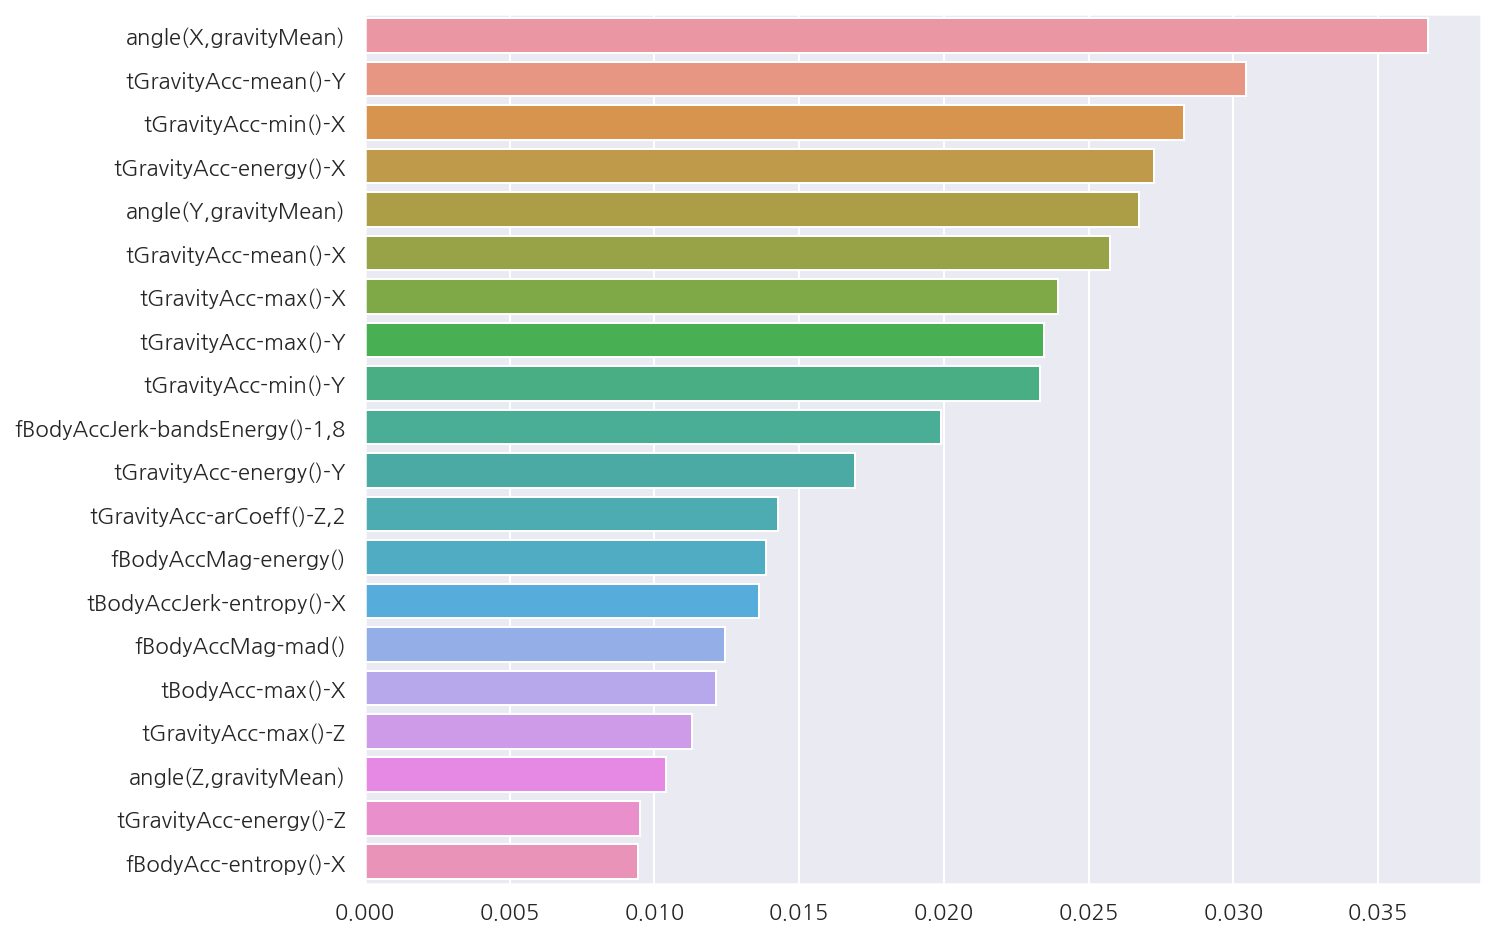

In [10]:
# 피처별 중요도 상위 20개
temp = best_rt_clf.feature_importances_
feature_importances_HAR_top20 = pd.Series(temp, index = X_train.columns).sort_values(ascending=False)[:20]
 
# 시각화
sns.barplot(x = feature_importances_HAR_top20, y = feature_importances_HAR_top20.index)
plt.show()

# 4. 부스팅

## 4.1 GBM(Gradient Boosting Machine)

GBM은 여러 개의 weak learner를 순차적으로 학습,예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다.

가중치의 업데이트 방법은 경사 하강법(Gradient Descent)을 사용한다.

- 경사 하강법(Gradient Descent)

    분류의 실제 결과값을 $y$, 피처를 $x_{1}, x_{2}, ..., x_{n}$, 피처에 기반한 예측 함수를 $F(x)$ 라고 할 때,

    오류식 $h(x) = y - F(x)$을 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것이다.

## 4.2 사용자 행동 인식 예제

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
import time

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정
start_time = time.time()

# GBM
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuray = accuracy_score(y_test,gb_pred)

print(f"GBM 정확도: {gb_accuray:.4f}")
print(f"GBM 수행 시간: {time.time() - start_time:.1f}초")

GBM 정확도: 0.9389
GBM 수행 시간: 1046.9초


## 4.3 GBM 하이퍼 파라미터

- `loss`: 경사 하강법에서 사용할 비용 함수를 지정한다. 특별한 이유가 없다면 디폴트 값 "deviance"를 적용한다.


- `learning_rate`: GBM이 학습을 진행할 때마다 적용하는 학습률로서 weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수

                  0~1 사이의 값을 지정할 수 있고 디폴트는 0.1이다.
                  
                  
                   값이 작을수록 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 크지만 수행 시간이 오래걸린다.
                  
                  
- `n_estimators`: weak learner의 갯수로 디폴트 값은 100이다.


- `subsample`: weak learner가 학습에 사하는 데이터의 샘플링 비율로 디폴트 값은 1이다. 

              과적합이 염려되는 경우 1보다 작은 값으로 설정한다

**GridSearchCV**

In [15]:
from sklearn.model_selection import GridSearchCV

params = {"n_estimators": [100, 500], "learning_rate": [0.05, 0.1]}

# GBM 객체 생성 후 GridSearchCV
gb_clf = GradientBoostingClassifier(random_state=0)
grid_cv2 = GridSearchCV(gb_clf, param_grid = params, cv=2, verbose=1)

grid_cv2.fit(X_train, y_train)

print("최고 예측 정확도:{0:.4f}".format(grid_cv2.best_score_))
print("최적 하이퍼 파라미터:\n", grid_cv2.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 217.5min finished


최고 예측 정확도:0.9011
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}


- GBM으로 간단히 최적 하이퍼 파라미터와 최고 예측 정확도를 구하였다.


- 소요시간이 굉장히 오래 걸리는 것을 확인 할 수 있다.

In [16]:
best_gb_clf = grid_cv2.best_estimator_
gb_pred = best_gb_clf.predict(X_test)
acc = accuracy_score(y_test, gb_pred)

print(f"예측 정확도:{acc: .4f}")

예측 정확도: 0.9420


- 앞서 확인한 최적 하이퍼 파라미터를 적용하였을 때 test 데이터 셋의 예측 정확도는 약 94.20%이다.